In [1]:
import pandas as pd

from tqdm.auto import tqdm
tqdm.pandas()

## Данные

собираю примеры из нескольких отдельных файлов

In [2]:
contrast_df = pd.read_csv('Data\contrast_clean_extended.tsv', sep='\t')
cause_df = pd.read_csv('Data\cause_clean_extended.tsv', sep='\t')

In [3]:
df1 = contrast_df
df1['relation'] = 'contrast'
df1.head()

,id,текст,relation
0,407,"В солнечный день, наверное, и вода играет друг...",contrast
1,921,там никто не в курсе никаких автобусов_говорят...,contrast
2,1051,В каком-то проёме за щёлкой эти монетки и оста...,contrast
3,1067,"Что ни говори, общий относительно приличный ур...",contrast
4,1161,"Коробка красивая,_прибор явно туфтовый, даже п...",contrast


In [4]:
df2 = cause_df
df2['relation'] = 'cause'
df2.head()

,id,текст,relation
0,24,"Помада довольно стойкая,_отлично переживет пер...",cause
1,101,Выпадает небольшой осадок._Всегда встряхиваю п...,cause
2,136,"зато есть ощущение, что присутствует муцин ули...",cause
3,206,"Не самый послушный,_может осыпаться под глаза.",cause
4,392,После октябрьской революции_монастырь официаль...,cause


склеиваю два датафрейма и проверяю, что нигде ничего не потерялось (нет пустых значений)

In [5]:
all_data = pd.concat([df1, df2], ignore_index=True)
all_data.isna().any()

id          False
текст       False
relation    False
dtype: bool

In [6]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
id          200 non-null int64
текст       200 non-null object
relation    200 non-null object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB


Разделяю пример на две ЭДЕ по `_`

In [7]:
new_df = all_data['текст'].str.split('_',expand=True)
new_df = new_df.rename(columns={0:'эде1', 1:'эде2'})
all_data = pd.concat([ all_data, new_df[['эде1', 'эде2']] ], axis=1)
all_data.head()

,id,текст,relation,эде1,эде2
0,407,"В солнечный день, наверное, и вода играет друг...",contrast,"В солнечный день, наверное, и вода играет друг...","Главное, что это не повод сидеть дома,"
1,921,там никто не в курсе никаких автобусов_говорят...,contrast,там никто не в курсе никаких автобусов,говорят; что всё на автостанцию приходит.
2,1051,В каком-то проёме за щёлкой эти монетки и оста...,contrast,В каком-то проёме за щёлкой эти монетки и оста...,И даже никаких чеков автомат не выдаёт.
3,1067,"Что ни говори, общий относительно приличный ур...",contrast,"Что ни говори, общий относительно приличный ур...",Автобусный транспорт реально много где на уров...
4,1161,"Коробка красивая,_прибор явно туфтовый, даже п...",contrast,"Коробка красивая,","прибор явно туфтовый, даже по внешнему виду."


# Признаки

считаю все признаки, которые можно получить автоматически

## Длины

Токенизирую тексты и считаю следующие параметры (учитывая только слова, без пунктуации):

`n_words` - кол-во слов в каждой ЭДЕ

`av_words_length` - средняя длина слова в каждой ЭДЕ

`n_words_diff` - разница в кол-вах между словами (знак показывает, какая из ЭДЕ длинее)

In [8]:
import re
from razdel import tokenize

In [9]:
def tokenizer(text_data):
    tokens = [_.text for _ in list(tokenize(str(text_data).lower()))] #if not re.search('[^а-яА-ЯёЁa-zA-z]', _.text)]
    return " ".join(tokens)

def get_words(tokens):
    words = [token for token in tokens.split() if not re.search('[^а-яА-ЯёЁa-zA-z]', token)]
    return " ".join(words)

def count_words(words):
    return len(words.split())

def av_word_length(words):
    l = [len(word) for word in words.split()]
    return sum(l)/len(l)

In [10]:
for i in ['1', '2']:
    all_data['tokens'+i] = all_data['эде'+i].progress_apply(tokenizer)
    all_data['words'+i] = all_data['tokens'+i].progress_apply(get_words)
    all_data['n_words'+i] = all_data['words'+i].progress_apply(count_words)
    all_data['av_words_length'+i] = all_data['words'+i].progress_apply(av_word_length)

In [11]:
all_data['n_words_diff'] = all_data['n_words1'] - all_data['n_words2']

Распределение длин

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
all_data.groupby(by='relation').mean()

,id,n_words1,av_words_length1,n_words2,av_words_length2,n_words_diff
relation,,,,,,
cause,7962.52,6.83,5.867120,6.50,5.849493,0.33
contrast,10371.23,8.38,5.774431,6.68,5.980861,1.70


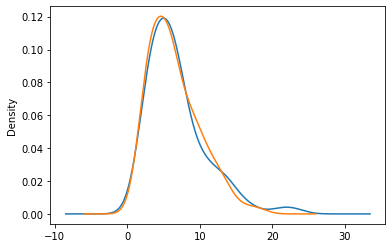

In [14]:
all_data[all_data['relation'] == 'cause']['n_words1'].plot.kde()
all_data[all_data['relation'] == 'cause']['n_words2'].plot.kde()

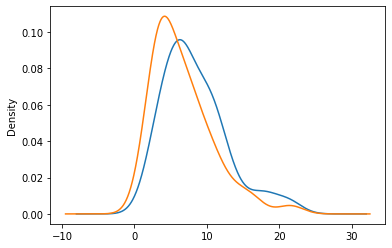

In [15]:
all_data[all_data['relation'] == 'contrast']['n_words1'].plot.kde()
all_data[all_data['relation'] == 'contrast']['n_words2'].plot.kde()

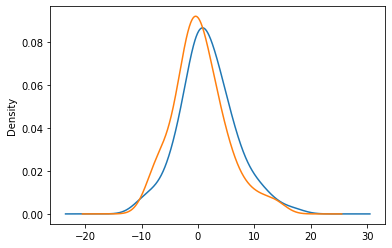

In [16]:
all_data[all_data['relation'] == 'contrast']['n_words_diff'].plot.kde()
all_data[all_data['relation'] == 'cause']['n_words_diff'].plot.kde()

## Пунктуация между ЭДЕ

`punct` - знак препинания между двумя ЭДЕ (беру последний токен первой ЭДЕ). _None_ если знаков там нет. Данные заранее нормализованы вручную так, чтобы знак оставался в первом элементе. 

In [17]:
def find_punct(tokens):
    last = tokens[-1]
    if last not in ['.', ',', ':', '-', '?', ')', '…']:
        last = 'none'
        
    return last

all_data['punct'] = all_data['tokens1'].apply(find_punct)
all_data['if punct'] = (all_data['punct'] != 'none')

## POS анализ

Считаю вектор со значениями всех частей речи и разбиваю его на отдельные признаки

In [18]:
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

In [19]:
tag_list = ['ADJF', 'ADJS', 'ADVB', 'COMP', 'CONJ', 'GRND', 'INFN', 'INTJ', 'NOUN',
            'NPRO', 'NUMR', 'None', 'PRCL', 'PRED', 'PREP', 'PRTF', 'PRTS', 'VERB']

In [20]:
def count_POS(words):
    POS_dict = {'ADJF': 0,
                'ADJS': 0,
                'ADVB': 0,
                'COMP': 0,
                'CONJ': 0,
                'GRND': 0,
                'INFN': 0,
                'INTJ': 0,
                'NOUN': 0,
                'NPRO': 0,
                'NUMR': 0,
                'None': 0,
                'PRCL': 0,
                'PRED': 0,
                'PREP': 0,
                'PRTF': 0,
                'PRTS': 0,
                'VERB': 0}
    
    for word in words.split():
        p = morph.parse(word)[0]
        tag = p.tag.POS
        if tag is None:
            tag = 'None'
        POS_dict[tag] += 1
    return list(POS_dict.values())

In [21]:
for i in ['1', '2']:
    all_data['pos_vector'+i] = all_data['words'+i].progress_apply(count_POS)
    
    all_data[ [tag+i for tag in tag_list] ] = pd.DataFrame(all_data['pos_vector'+i].tolist())

## Повторяющиеся слова

Лемматизирую тексты и считаю сколько слов встречаются в обеих ЭДЕ

In [22]:
def lemmatizer(words):
    lem_text = []
    for word in words.split():
        lem = morph.parse(word)[0].normal_form
#         if lem not in stops:
        lem_text.append(lem)
    return ' '.join(lem_text)

def similar_words(lemm_a, lemm_b):
    return list(set(lemm_a.split()) & set(lemm_b.split()))

In [23]:
for i in ['1', '2']:
    all_data['lemm'+i] = all_data['words'+i].progress_apply(lemmatizer)

In [24]:
all_data['similar_words'] = all_data.apply(lambda x: similar_words(x['lemm1'], x['lemm2']), axis=1)
all_data['n_similar_words'] = all_data['similar_words'].apply(len)

In [25]:
all_data[all_data['n_similar_words'] != 0]['similar_words']

2                                          [и]
3                         [уровень, транспорт]
9                                          [с]
11                                    [бывать]
15                                       [кот]
18                                    [писать]
20                                       [для]
21                                  [хотеться]
22          [путь, к, это, результат, быстрый]
23                         [быть, пищеварение]
25                           [тестер, платить]
26                                  [работать]
27                         [требовать, ресурс]
28                                    [способ]
30                                       [что]
32                                [технология]
34                                        [не]
35                                 [я, хотеть]
37                     [сказать, мочь, я, что]
39                                  [удобство]
41                   [нужно, значит, что, это]
42           

## Эмбединги

Обучаю модель, получаю вектора размерности 10 для каждой пары ЭДЕ и считаю их косинусную близовть. Вектора разбиваю на 10 отдельных признаков. Как дальше покажут эксперименты, если использовать эти 10 отдельных признаков, то почти все модели получаются сильно завязаны на каку-то их часть, при этом если их не использовать - качество не особо и меняется. Так что в итоге при обучении я буду использовать только значение близости между векторами двух ЭДЕ `cosine_d2v`.

### doc2vec

In [26]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [27]:
corpora = all_data['lemm1'].values.tolist() + all_data['lemm2'].values.tolist()
len(corpora)

400

In [28]:
documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(corpora)]
model = Doc2Vec(documents, vector_size=10, window=2, min_count=1)

In [29]:
def get_d2v_vector(lemm):
    return model.infer_vector(lemm.split())

def cosine_d2v(lemm1, lemm2):
    return model.wv.n_similarity(lemm1.split(),lemm2.split())

In [30]:
for i in ['1', '2']:
    all_data['d2v_vector'+i] = all_data['lemm'+i].progress_apply(get_d2v_vector)
    all_data[ ['v'+str(n)+'_'+i for n in range(10)] ] = pd.DataFrame(all_data['d2v_vector'+i].tolist())

In [31]:
all_data['cosine_d2v'] = all_data.apply(lambda x: cosine_d2v(x['lemm1'], x['lemm2']), axis=1)

### Сохранение всех результатов в экселе

In [32]:
all_data.to_excel('Data\data_full_markup.xlsx')

# Модели

In [33]:
import numpy as np
from sklearn.metrics import classification_report

## Обчающая и тестовая выборки

In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [35]:
not_features = ['id', 'текст',
                'эде1', 'эде2',
                'tokens1', 'tokens2',
                'words1', 'words2',
                'pos_vector1', 'pos_vector2',
                'lemm1', 'lemm2',
                'similar_words', 'if punct', 
                'd2v_vector1', 'd2v_vector2']

not_features.extend(['v'+str(n)+'_'+'1' for n in range(10)])
not_features.extend(['v'+str(n)+'_'+'2' for n in range(10)])

features_list = list(set(all_data.columns.values.tolist()) - set(not_features))
features_list.remove('relation')

data = all_data.drop(columns=not_features)
data = data.apply(LabelEncoder().fit_transform) # 1 = contrast, 0 = cause

X = data.drop(columns=['relation'])
y = data['relation']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=42)

In [36]:
len(features_list)

44

In [37]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 154 to 5
Data columns (total 44 columns):
n_words1            160 non-null int64
av_words_length1    160 non-null int64
n_words2            160 non-null int64
av_words_length2    160 non-null int64
n_words_diff        160 non-null int64
punct               160 non-null int32
ADJF1               160 non-null int64
ADJS1               160 non-null int64
ADVB1               160 non-null int64
COMP1               160 non-null int64
CONJ1               160 non-null int64
GRND1               160 non-null int64
INFN1               160 non-null int64
INTJ1               160 non-null int64
NOUN1               160 non-null int64
NPRO1               160 non-null int64
NUMR1               160 non-null int64
None1               160 non-null int64
PRCL1               160 non-null int64
PRED1               160 non-null int64
PREP1               160 non-null int64
PRTF1               160 non-null int64
PRTS1               160 non-null int6

## Корреляция признаков

вроде сильно коррелирующих нет

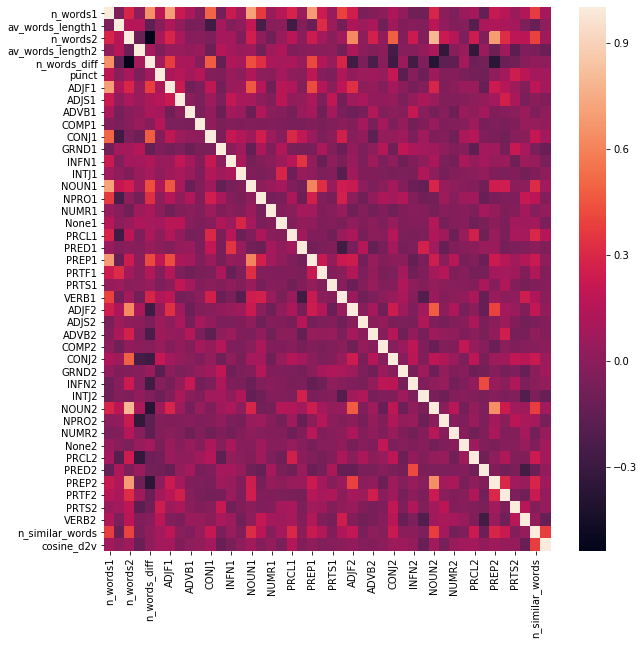

In [38]:
corr_matrix = data.drop(columns=['relation']).corr()
plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix)

### Корреляция между признаками и классом

In [39]:
feature_corr = np.empty(0)

for f in features_list:
    feature_corr = np.append(feature_corr, data[['relation', f]].corr()['relation'][f])
    
for ind in np.argsort(-feature_corr):
    print(features_list[ind], '-', feature_corr[ind])

n_similar_words - 0.24938907724170786
PRCL2 - 0.22423052782558048
n_words1 - 0.18248905029295673
PRCL1 - 0.16947553762062917
ADJF1 - 0.16485989852481342
ADJS1 - 0.15309310892394895
NOUN1 - 0.14864888347169689
n_words_diff - 0.1396137509584346
ADJF2 - 0.12121830534626488
VERB1 - 0.12027695586485297
INTJ2 - 0.11724207635210979
punct - 0.09976037959994381
CONJ1 - 0.0970494958830943
INFN1 - 0.08835852486128691
cosine_d2v - 0.08435192873430357
INTJ1 - 0.08161943426864189
NUMR1 - 0.07142857142857151
None2 - 0.07088812050083323
PRTF2 - 0.060845543573612736
PREP2 - 0.05463583647081531
PRED1 - 0.05324139056496659
PREP1 - 0.05200401152588276
av_words_length2 - 0.02976722807720608
ADJS2 - 0.02720647808954716
NOUN2 - 0.025854491181538285
CONJ2 - 0.025822040901125175
n_words2 - 0.01857273628971618
av_words_length1 - -0.012286604849893192
NPRO2 - -0.018979740450028024
None1 - -0.019924430474521027
COMP1 - -0.02411915350974739
NPRO1 - -0.03907323325822833
PRTS1 - -0.041134503489486336
ADVB1 - -0.0500

## Статистическая значимость признаков

без комментариев

In [40]:
from sklearn.feature_selection import chi2

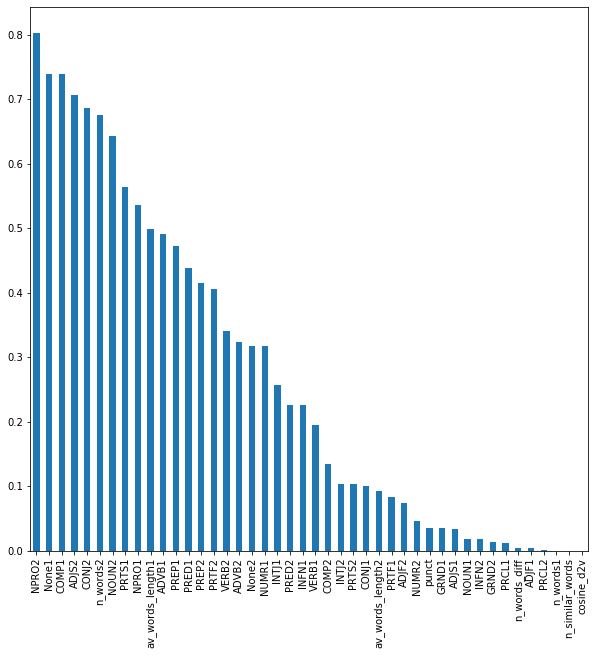

In [41]:
chi_scores = chi2(X, y)
p_values = pd.Series(chi_scores[1], index = X.columns)
p_values.sort_values(ascending = False, inplace = True)
plt.subplots(figsize=(10,10))
p_values.plot.bar()

## Логистическая регрессия

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
lreg = LogisticRegression(random_state=42)
lreg.fit(X_train, y_train)

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
y_pred_lreg = lreg.predict(X_test)
print(classification_report(y_test, y_pred_lreg))

              precision    recall  f1-score   support

           0       0.64      0.90      0.75        20
           1       0.83      0.50      0.62        20

    accuracy                           0.70        40
   macro avg       0.74      0.70      0.69        40
weighted avg       0.74      0.70      0.69        40



In [45]:
feature_importances_lreg = lreg.coef_
for ind in np.argsort(-feature_importances_lreg[0]):
    print(X_train.columns[ind], '-', feature_importances_lreg[0][ind])

ADJS1 - 1.0926052685517167
INTJ1 - 0.9531457388668532
n_similar_words - 0.8131207284309575
PRCL2 - 0.6407257405370884
ADJF2 - 0.5617537288789896
INTJ2 - 0.5553221569008576
VERB1 - 0.529420924472552
NPRO2 - 0.471563501968951
PREP2 - 0.43430349270129337
None2 - 0.4325108745368614
NUMR1 - 0.3797468144777583
PRED1 - 0.35527071617372125
CONJ2 - 0.2520641184413455
ADJF1 - 0.2356405053550953
PRCL1 - 0.23334104984558549
INFN1 - 0.14035458140616625
punct - 0.14028000028853324
n_words1 - 0.13503876223859185
ADVB1 - 0.11926330444569667
ADJS2 - 0.08926210557505608
NOUN1 - 0.0807572206399138
COMP2 - 0.07255057846448508
NOUN2 - 0.0390615027973567
PRTS1 - 0.02411174725835533
av_words_length2 - 0.008137028396664235
av_words_length1 - 0.003928012292981928
cosine_d2v - -0.0008242745564194075
PRED2 - -0.042218842726422734
PREP1 - -0.0945211291984596
n_words_diff - -0.12135796439895563
CONJ1 - -0.12141102606322829
PRTF2 - -0.2058418859611028
ADVB2 - -0.20898365661499144
VERB2 - -0.2662335695351152
GRND1 -

## Decision Tree

In [46]:
from sklearn.tree import DecisionTreeClassifier

In [47]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [48]:
y_pred_tree = tree_clf.predict(X_test)
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.52      0.65      0.58        20
           1       0.53      0.40      0.46        20

    accuracy                           0.53        40
   macro avg       0.53      0.53      0.52        40
weighted avg       0.53      0.53      0.52        40



In [49]:
feature_importances_tree = tree_clf.feature_importances_
for ind in np.argsort(-feature_importances_tree):
    print(X_train.columns[ind], '-', feature_importances_tree[ind])

n_words2 - 0.12841461213837527
n_similar_words - 0.10121457489878546
n_words1 - 0.08490036231884056
NPRO1 - 0.06959751996637242
cosine_d2v - 0.0632440476190476
n_words_diff - 0.0604370596302076
PRCL2 - 0.057696270558031684
av_words_length1 - 0.04404761904761905
GRND1 - 0.04292679479932162
INFN1 - 0.036111111111111094
CONJ2 - 0.035416666666666666
NPRO2 - 0.03333333333333333
ADJF2 - 0.0319790642223451
ADJS1 - 0.03109507954125048
GRND2 - 0.029701468710089385
VERB1 - 0.023116395099153707
COMP2 - 0.02291666666666667
INFN2 - 0.0188673469387755
NOUN2 - 0.01875
PRTF1 - 0.018409586056644896
ADVB1 - 0.018127450980392146
PREP1 - 0.01666666666666667
NOUN1 - 0.00719696969696971
PRED1 - 0.0058333333333333405
VERB2 - 0.0
PRTS2 - 0.0
PRTF2 - 0.0
PREP2 - 0.0
PRED2 - 0.0
ADJF1 - 0.0
None2 - 0.0
NUMR2 - 0.0
INTJ2 - 0.0
CONJ1 - 0.0
INTJ1 - 0.0
av_words_length2 - 0.0
ADVB2 - 0.0
ADJS2 - 0.0
NUMR1 - 0.0
None1 - 0.0
PRTS1 - 0.0
PRCL1 - 0.0
COMP1 - 0.0
punct - 0.0


## Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [52]:
y_pred_forest = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred_forest))

              precision    recall  f1-score   support

           0       0.62      0.80      0.70        20
           1       0.71      0.50      0.59        20

    accuracy                           0.65        40
   macro avg       0.66      0.65      0.64        40
weighted avg       0.66      0.65      0.64        40



In [53]:
feature_importances_forest = rf_clf.feature_importances_
for ind in np.argsort(-feature_importances_forest):
    print(X_train.columns[ind], '-', feature_importances_forest[ind])

av_words_length1 - 0.06987827976545953
cosine_d2v - 0.06683527283393702
av_words_length2 - 0.0650065990018059
n_similar_words - 0.06275774640960004
n_words1 - 0.05731089490010717
n_words_diff - 0.055265220951278976
n_words2 - 0.04572808201236842
NOUN1 - 0.04472933053519498
NOUN2 - 0.040606279223169436
ADJF2 - 0.034934590779201934
punct - 0.0341126209314709
PRCL1 - 0.029418667967648693
ADJF1 - 0.029061164264657355
PREP2 - 0.027823720840016213
VERB1 - 0.025445869240594898
CONJ1 - 0.024355039904657337
PRCL2 - 0.02405047655294471
VERB2 - 0.022675314891483667
PREP1 - 0.019591018427045404
ADVB2 - 0.019481724605882413
ADVB1 - 0.019288354103033464
NPRO1 - 0.019265396900555634
INFN2 - 0.017068943941978956
INFN1 - 0.016173080894703498
GRND2 - 0.015602674098215124
CONJ2 - 0.01434934492165462
NPRO2 - 0.011873667679375772
ADJS1 - 0.011792614161598842
GRND1 - 0.010727624552556476
PRTF1 - 0.010508507736523296
INTJ1 - 0.006913126553814419
COMP2 - 0.006775805528128782
PRED1 - 0.0065033104291720035
COMP

## SVM

In [54]:
from sklearn.svm import SVC

In [55]:
svc = SVC(kernel='linear', random_state=42)
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

In [56]:
y_pred_svc = svc.predict(X_test)
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.65      0.85      0.74        20
           1       0.79      0.55      0.65        20

    accuracy                           0.70        40
   macro avg       0.72      0.70      0.69        40
weighted avg       0.72      0.70      0.69        40



In [57]:
feature_importances_svc = svc.coef_
for ind in np.argsort(-feature_importances_svc[0]):
    print(X_train.columns[ind], '-', feature_importances_svc[0][ind])

INTJ1 - 1.1009265330307363
ADJS1 - 0.8550911780416364
n_similar_words - 0.7757032620555566
PRCL2 - 0.6466692574940685
None2 - 0.62127957743971
n_words1 - 0.5263399670859403
NPRO2 - 0.49562008702683036
VERB1 - 0.41261735545983225
PREP2 - 0.35226700046527526
NUMR1 - 0.3513886013584876
PRED1 - 0.3438336763167309
INTJ2 - 0.32539317051817607
CONJ2 - 0.30260412449187046
COMP2 - 0.2863590838001458
ADJF2 - 0.2505581414267728
PRTS1 - 0.23600388445749865
ADJF1 - 0.2333135517121847
INFN1 - 0.1901316944247533
PRCL1 - 0.18306062658972166
ADJS2 - 0.1655754278103329
PREP1 - 0.1410165600552742
punct - 0.1005779797213906
NOUN1 - 0.05654625865187324
av_words_length2 - 0.015663848678749925
av_words_length1 - 0.004349250410267569
cosine_d2v - 0.0006839015940203197
PRTS2 - 0.0
ADVB1 - -0.06201357357200998
NOUN2 - -0.06962793113045551
NUMR2 - -0.20240999284577926
CONJ1 - -0.20788481995629882
VERB2 - -0.2213356343685171
PRED2 - -0.236900888905613
INFN2 - -0.2659408011161819
GRND1 - -0.2826862480013719
ADVB2 

## Сравнение качества моделей

### F1-score

In [58]:
pd.DataFrame({
    'LReg': [classification_report(y_test, y_pred_lreg, output_dict=True)['0']['f1-score'], classification_report(y_test, y_pred_lreg, output_dict=True)['1']['f1-score']],
    'DTree': [classification_report(y_test, y_pred_tree, output_dict=True)['0']['f1-score'], classification_report(y_test, y_pred_tree, output_dict=True)['1']['f1-score']],
    'RForest': [classification_report(y_test, y_pred_forest, output_dict=True)['0']['f1-score'], classification_report(y_test, y_pred_forest, output_dict=True)['1']['f1-score']],
    'SVM': [classification_report(y_test, y_pred_svc, output_dict=True)['0']['f1-score'], classification_report(y_test, y_pred_svc, output_dict=True)['1']['f1-score']]
}, index=['cause', 'contrast'])

,LReg,DTree,RForest,SVM
cause,0.750,0.577778,0.695652,0.739130
contrast,0.625,0.457143,0.588235,0.647059


### Precision

In [59]:
pd.DataFrame({
    'LReg': [classification_report(y_test, y_pred_lreg, output_dict=True)['0']['precision'], classification_report(y_test, y_pred_lreg, output_dict=True)['1']['precision']],
    'DTree': [classification_report(y_test, y_pred_tree, output_dict=True)['0']['precision'], classification_report(y_test, y_pred_tree, output_dict=True)['1']['precision']],
    'RForest': [classification_report(y_test, y_pred_forest, output_dict=True)['0']['precision'], classification_report(y_test, y_pred_forest, output_dict=True)['1']['precision']],
    'SVM': [classification_report(y_test, y_pred_svc, output_dict=True)['0']['precision'], classification_report(y_test, y_pred_svc, output_dict=True)['1']['precision']]
}, index=['cause', 'contrast'])

,LReg,DTree,RForest,SVM
cause,0.642857,0.520000,0.615385,0.653846
contrast,0.833333,0.533333,0.714286,0.785714


### Recall

In [60]:
pd.DataFrame({
    'LReg': [classification_report(y_test, y_pred_lreg, output_dict=True)['0']['recall'], classification_report(y_test, y_pred_lreg, output_dict=True)['1']['recall']],
    'DTree': [classification_report(y_test, y_pred_tree, output_dict=True)['0']['recall'], classification_report(y_test, y_pred_tree, output_dict=True)['1']['recall']],
    'RForest': [classification_report(y_test, y_pred_forest, output_dict=True)['0']['recall'], classification_report(y_test, y_pred_forest, output_dict=True)['1']['recall']],
    'SVM': [classification_report(y_test, y_pred_svc, output_dict=True)['0']['recall'], classification_report(y_test, y_pred_svc, output_dict=True)['1']['recall']]
}, index=['cause', 'contrast'])

,LReg,DTree,RForest,SVM
cause,0.9,0.65,0.8,0.85
contrast,0.5,0.40,0.5,0.55


## Сравнение важности признаков

Сравниваю абсолютные значения всех признаков

In [61]:
features = pd.DataFrame({'LReg': abs(feature_importances_lreg[0]), 
              'DTree': feature_importances_tree, 
              'RForest': feature_importances_forest,
              'SVM': abs(feature_importances_svc[0]),}, index=X_train.columns)

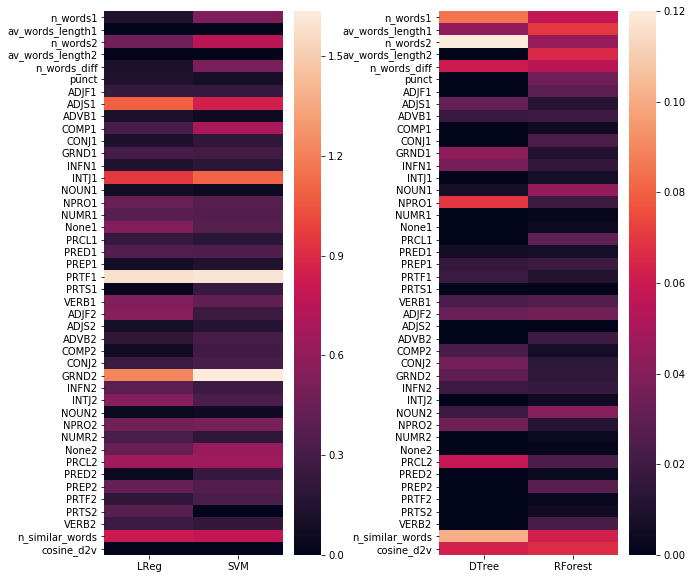

In [62]:
fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(10,10))
fig.subplots_adjust(wspace=0.5)
sns.heatmap(features[['LReg', 'SVM']], cmap="rocket", ax=ax, cbar=True, vmin=0)
sns.heatmap(features[['DTree', 'RForest']], cmap="rocket", ax=ax2, cbar=True, vmax=0.12)
plt.show()

In [63]:
features

,LReg,DTree,RForest,SVM
n_words1,0.135039,0.084900,0.057311,0.526340
av_words_length1,0.003928,0.044048,0.069878,0.004349
n_words2,0.462487,0.128415,0.045728,0.751739
av_words_length2,0.008137,0.000000,0.065007,0.015664
n_words_diff,0.121358,0.060437,0.055265,0.509495
punct,0.140280,0.000000,0.034113,0.100578
ADJF1,0.235641,0.000000,0.029061,0.233314
ADJS1,1.092605,0.031095,0.011793,0.855091
ADVB1,0.119263,0.018127,0.019288,0.062014
COMP1,0.315215,0.000000,0.005398,0.688052


_Анна Полянская, НИУ ВШЭ, 2020_